#  BERT Classifier
- Group 14
- Kaggle Team Name: Yellow Submarine
    - Score: 0.59839,   Rank: 4
- Team members (Student Name & ID & kaggle display name):
    - YUAN Yanzhe: 20728555  (bighead)
    - LIU Donghua: 20731100  (Danhuang)
    - SHEN Dinghui: 20726478  (mengnan)
- Run on: Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/6000_proj1')

In [3]:
!pip install transformers
!pip install nltk
import nltk
nltk.download('stopwords')

     |████████████████████████████████| 2.2MB 11.3MB/s 
     |████████████████████████████████| 870kB 40.9MB/s 
     |████████████████████████████████| 3.3MB 29.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=62ca7166f5866246a2057f143c1c5068b803e10f50ddd367d0fc518a09ec6267
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# machine laerning packages
import os
import re
import math
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

import nltk
from nltk.corpus import stopwords


# deep learning packages
import torch
from torch import nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# settings
stopwords = set(stopwords.words("english"))    
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


## 1. Data Proprocessing

- lower word
- re filtering
- stopword filtering

In [5]:
# preprocessing

def load_data(file_name):
    df = pd.read_csv(file_name)
    return df, df['text'], df['context'], df['impact_label']

def preprocessing(text, lower_word=True, re_word=True, stop_word=True):
    # input: text:str
    # output: preprocessed sentence:str
    
    # lower_word
    if lower_word:
        text = text.lower()
    
    # re_word
    if re_word:
         text = text.strip('[]').replace("'", "").replace("'", "").replace("%", " percent ")\
                    .replace("$", " dollar ").replace('&', ' and ').replace("-", " ")
                    #.replace('.','').replace('"', "")    
    # stop_word
    if stop_word:
        text = ' '.join([word for word in text.split() if word not in stopwords])
        # remove whitespace
        text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [6]:
# Load Data
train_raw, train_raw_text, train_raw_context, train_raw_label = load_data('data/train.csv')
valid_raw, valid_raw_text, valid_raw_context, valid_raw_label = load_data('data/valid.csv')
test_raw, test_raw_text, test_raw_context, test_raw_label = load_data('data/test.csv')

train_raw.head()
#valid_raw.head()
#test_raw.head()

,id,text,context,stance_label,impact_label
0,train_0,All adoption agencies conduct interviews and h...,['A license should be required in order to hav...,"['NULL', 'OPPOSE', 'OPPOSE', 'SUPPORT']",MEDIUM_IMPACT
1,train_1,Genetically modified crops need fewer scarce r...,['The sale of genetically modified food should...,"['NULL', 'OPPOSE', 'SUPPORT']",IMPACTFUL
2,train_2,Some of Antifa's actions may be morally questi...,['Democrats should not cooperate with Donald T...,"['NULL', 'OPPOSE', 'SUPPORT', 'OPPOSE', 'SUPPO...",MEDIUM_IMPACT
3,train_3,Most pet lovers eat animals.,['People should donate to organisations that s...,"['NULL', 'OPPOSE', 'OPPOSE', 'OPPOSE', 'SUPPORT']",MEDIUM_IMPACT
4,train_4,Biologically-driven reproductive desires are c...,['Gender (the concept of masculinity and femin...,"['NULL', 'SUPPORT', 'SUPPORT', 'OPPOSE', 'SUPP...",IMPACTFUL


In [7]:
# Do Preprocessing
# train and valid data
train_text = [preprocessing(text, lower_word=True, re_word=True, stop_word=True) for text in train_raw_text]
valid_text = [preprocessing(text, lower_word=True, re_word=True, stop_word=True) for text in valid_raw_text]
train_context = [preprocessing(text, lower_word=True, re_word=True, stop_word=True) for text in train_raw_context]
valid_context = [preprocessing(text, lower_word=True, re_word=True, stop_word=True) for text in valid_raw_context]

class_to_label = {'NOT_IMPACTFUL':0, 'MEDIUM_IMPACT':1, 'IMPACTFUL':2}
train_label = train_raw_label.map(class_to_label).tolist()
valid_label = valid_raw_label.map(class_to_label).tolist()

print(len(train_text))
print(len(train_context))
print(len(train_label))
print(len(valid_text))
print(len(valid_context))
print(len(valid_label))

# test data
test_text = [preprocessing(text, lower_word=True, re_word=True, stop_word=True) for text in test_raw_text]
test_context = [preprocessing(text, lower_word=True, re_word=True, stop_word=True) for text in test_raw_context]
test_label = test_raw_label.map({'UNKNOWN':-1})
print(len(test_text))
print(len(test_context))


5170
5170
5170
1108
1108
1108
1108
1108


## EDA

- class imbalance
- max_length

In [8]:
# See Stats
print('The shape of train data: ', train_raw.shape)
print('The shape of valid data: ', valid_raw.shape)
#print('The shape of test data: ', test_raw.shape)
print('\n# of NULL value in train data:\n', train_raw.isnull().sum())
print('# of NULL value in valid data:\n', valid_raw.isnull().sum())
#print('# of NULL value in valid data:\n', test_raw.isnull().sum())

train_imbalance = train_raw.impact_label.value_counts()
valid_imbalance = valid_raw.impact_label.value_counts()
print('\nimbalance in train data\n', train_imbalance)
print('imbalance in valid data\n', valid_imbalance)

The shape of train data:  (5170, 5)
The shape of valid data:  (1108, 5)

# of NULL value in train data:
 id              0
text            0
context         0
stance_label    0
impact_label    0
dtype: int64
# of NULL value in valid data:
 id              0
text            0
context         0
stance_label    0
impact_label    0
dtype: int64

imbalance in train data
 IMPACTFUL        3021
NOT_IMPACTFUL    1126
MEDIUM_IMPACT    1023
Name: impact_label, dtype: int64
imbalance in valid data
 IMPACTFUL        641
NOT_IMPACTFUL    252
MEDIUM_IMPACT    215
Name: impact_label, dtype: int64


In [9]:
# determine class weight
# from sklearn.utils.class_weight import compute_class_weight

# class_weight = compute_class_weight('balanced',np.unique(train_label+valid_label),train_label+valid_label).astype(np.float64)
# class_weight = torch.FloatTensor(class_weight)


In [10]:
test_raw.head()

,id,text,context,stance_label,impact_label
0,test_0,['Cloning animals advances science in that sci...,"['Cloning animals is ethical', 'The possible s...","['NULL', 'SUPPORT', 'SUPPORT']",UNKNOWN
1,test_1,['Propaganda was widely used before the 20th c...,"['Europeans, defined as citizens of what today...","['NULL', 'OPPOSE', 'SUPPORT', 'OPPOSE']",UNKNOWN
2,test_2,['Polygamous marriages bear a high likelihood ...,"['Polygamy should be legal', 'Polygamy can hav...","['NULL', 'SUPPORT', 'SUPPORT']",UNKNOWN
3,test_3,['White supremacists threaten and endanger a v...,['Internet companies are wrong in denying serv...,"['NULL', 'OPPOSE']",UNKNOWN
4,test_4,['Voters would be able to better determine the...,['Abolishing all aspects of privacy (through a...,"['NULL', 'SUPPORT', 'SUPPORT']",UNKNOWN


In [11]:
# find MAX_LENGTH
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
all_data = train_context+train_text\
            +valid_context+valid_text\
            +test_context+test_text
sents_encode = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]
sent_lens = [len(sent) for sent in sents_encode]
print('Max length: ', max(sent_lens))


Max length:  442


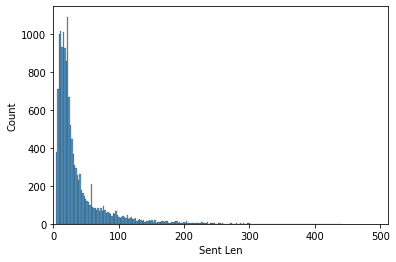

In [13]:
import seaborn as sns
sns.histplot(sent_lens)
plt.xlim([0,512])
plt.xlabel('Sent Len');

## Data Preprocessing Method 2

In [14]:
# df1 = pd.read_csv("train.csv")
# df2 = pd.read_csv("valid.csv")
# df = df1.append(df2)
# df.shape

In [15]:
# plt.style.use('ggplot')
# sns.countplot(df.impact_label)
# plt.xlabel('label')

In [16]:
# def to_numerical(label):
#     if label == "IMPACTFUL":
#         return 2
#     elif label == "MEDIUM_IMPACT":
#         return 1
#     else:
#         return 0
# df["impact_label"] = df.impact_label.apply(to_numerical)

In [17]:
# def processtext(x):
#     text = x
#     text = text.replace('[','').replace(']','')
#     text = text.replace('\"','\'')
#     return text

# def process_stance(x):
#     text = x
#     text = text.replace('[','').replace(']','')
#     return text

In [18]:
# df.context = df.context.apply(lambda x : processtext(x))
# df.stance_label = df.stance_label.apply(lambda x : process_stance(x))

In [19]:
# def merge_stance1(text, stance_label):   # combine the text with the last stance label word in 'stance_label'
#     label_list = stance_label.split(',')
#     label_list.insert(0, label_list[-1])
#     label_list.pop()
#     output_list = text + label_list[0]
#     return output_list

# def merge_stance2(context, stance_label): # combine all the  sentence in context with the corresponding stance label
#     label_list = stance_label.split(',')
#     label_list.insert(0, label_list[-1])
#     label_list.pop()
#     context_list = context.split("\', \'")
#     output_list = []
#     num = len(label_list) - 1
#     for i in range(num):
#         output_list.append(context_list[i] + label_list[i+1])
#     return output_list

In [20]:
# df['text_with_stance'] = df[["text", "stance_label"]].apply(lambda x : merge_stance1(x["text"], x["stance_label"]), axis=1)
# df['context_with_stance'] = df[["context", "stance_label"]].apply(lambda x : merge_stance2(x["context"], x["stance_label"]), axis=1)
# df['context_with_stance'] = df['context_with_stance'].str.join(' ')
# df.index = range(len(df))
# pd.DataFrame(df,columns = ['text_with_stance', 'context_with_stance', 'impact_label']).to_csv("train1.csv")

In [21]:
# df_test = pd.read_csv("test.csv")
# df_test['text'] = df_test.text.apply(lambda x : processtext(x))
# df_test['context'] = df_test.context.apply(lambda x : processtext(x))
# df_test.stance_label = df_test.stance_label.apply(lambda x : process_stance(x))
# df_test['context_with_stance'] = df_test[["context", "stance_label"]].apply(lambda x : merge_stance2(x["context"], x["stance_label"]), axis=1)
# df_test['text_with_stance'] = df_test[["text", "stance_label"]].apply(lambda x : merge_stance1(x["text"], x["stance_label"]), axis=1)
# df_test['context_with_stance'] = df_test['context_with_stance'].str.join(' ')
# df_test.index = range(len(df_test))
# pd.DataFrame(df_test,columns = ['text_with_stance', 'context_with_stance']).to_csv('test1.csv', index = False)

## 2. Model: BERT


### 2.1 bert pipeline

- Load Data
  - class BertDataPreprocessor: to make all data into BERT input.
  - def data_loader: to transfer datasets into the form of PyTorch DataLoader.
- Define Model
  - BERT (pooler_output/last_hidden_state)
  - dropout
  - linear
- Train Model
  - train and eval
  - train on the whole dataset

In [22]:
# Hyperparameters: for tuning

PRETRAINED_MODEL = 'bert-base-uncased'  # 'xlnet-base-cased','distilbert'
MAX_LENGTH = 256  # 512
BATCH_SIZE = 32
EPOCHS = 8

bert_model = BertModel.from_pretrained(PRETRAINED_MODEL)
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)

##### We also merge the train and valid data together as a whole and split into new train and valid data

In [23]:
# Data Loader: transfer data into BERT input

class BertDataPreprocessor():
    def __init__(self, text, context, label, tokenizer, max_len):
        self.text = text
        self.context = context
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        context = self.context[item]
        text = self.text[item]
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
            #context,
            text,
            context,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {'context':context, 'text':text, 'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)}
        # token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  


def data_loader(text, context, label, tokenizer, max_len, batch_size):
    data = BertDataPreprocessor(
        text=text,
        context=context,
        label=label,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(data, batch_size=batch_size,num_workers=4)


# ---Train Model 1.0: train and eval---
train_data_loader = data_loader(train_text, train_context, train_label, tokenizer, MAX_LENGTH, BATCH_SIZE)
valid_data_loader = data_loader(valid_text, valid_context, valid_label, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_data_loader = data_loader(test_text, test_context, test_label, tokenizer, MAX_LENGTH, BATCH_SIZE)


# ---Train Model 2.0: train the whole dataset---
# train_text_full = train_text + valid_text
# train_context_full = train_context + valid_context
# train_label_full = train_label + valid_label

# train_data_loader = data_loader(train_text_full, train_context_full, train_label_full, tokenizer, MAX_LENGTH, BATCH_SIZE)
# test_data_loader = data_loader(test_text, test_context, test_label, tokenizer, MAX_LENGTH, BATCH_SIZE)
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
# check output
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


In [25]:
# Define Model

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, num_class):
        super(BertClassifier,self).__init__()
        self.bert = pretrained_model  #BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.Sequential(
                      nn.Linear(self.bert.config.hidden_size, 128),
                      nn.ReLU(),
                      nn.Dropout(p=0.5),
                      nn.Linear(128, num_class)
        )
#         self.linear = nn.Linear(self.bert.config.hidden_size, num_class)
        
    def forward(self, input_ids, attention_mask):
        res = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        res = self.dropout(res['last_hidden_state'][:,0,:])  # res['last_hidden_state'][:,0,:], res['pooler_output']
        res = self.linear(res)
        return res

# settings
net = BertClassifier(bert_model, len(class_to_label)).to(device)
#print(net)

optimizor = AdamW(net.parameters(), lr=2e-5, correct_bias=False)
loss_func = nn.CrossEntropyLoss().to(device)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer=optimizor, num_warmup_steps=0, num_training_steps=total_steps)


In [26]:
# def set_seed(seed):
#     """ Set all seeds to make results reproducible """
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)

In [27]:
# def train_test_split(data_df, test_size=0.2, shuffle=True, random_state=None):
#     if shuffle:
#         data_df = reset(data_df, random_state=random_state)
	
#     train = data_df[int(len(data_df)*test_size):].reset_index(drop = True)
#     test  = data_df[:int(len(data_df)*test_size)].reset_index(drop = True)

#     return train, test

In [28]:
def train_model(net, data_loader, optimizor, loss_func, scheduler, num_data, device):
    net = net.train()  # open up dropout and normalization
    preds, total_l, correct = [], [], 0
    
    for data in data_loader:
        # data
        input_ids, attention_mask = data['input_ids'].to(device), data['attention_mask'].to(device)
        y = data['label'].to(device)
        
        # pipeline
        output = net(input_ids=input_ids, attention_mask=attention_mask)
        _, pred = torch.max(output,dim=1)  # values, indices = torch.max(), use indices to reflect pred_labels
        loss = loss_func(output,y)
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        
        optimizor.step()
        scheduler.step()
        
        optimizor.zero_grad()
        
        # record stats
        preds.append(pred)
        correct += torch.sum(pred==y)
        total_l.append(loss.item())

        
    return correct.double()/num_data, np.mean(total_l), torch.cat(preds, dim=0).cpu()

def eval_model(net, data_loader, loss_func, num_data, device):
    net = net.eval() 
    preds, total_l, correct = [], [], 0
    
    with torch.no_grad():
        for data in data_loader:
            # data
            input_ids, attention_mask = data['input_ids'].to(device), data['attention_mask'].to(device)
            y = data['label'].to(device)
        
            # pipeline: just foward
            output = net(input_ids=input_ids, attention_mask=attention_mask)
            _, pred = torch.max(output,dim=1)  
            loss = loss_func(output,y)
        
            # record stats
            preds.append(pred)
            correct += torch.sum(pred==y)
            total_l.append(loss.item())
    
    return correct.double()/num_data, np.mean(total_l), torch.cat(preds, dim=0).cpu()

def test_model(net, data_loader):
    net = net.eval()
    preds, pred_probs = [],[]
    
    with torch.no_grad():
        for data in data_loader:
            # data
            input_ids, attention_mask = data['input_ids'].to(device), data['attention_mask'].to(device)
            y = data['label'].to(device)
            
            # pipeline
            output = net(input_ids=input_ids, attention_mask=attention_mask)
            _, pred = torch.max(output,dim=1)
            
            preds.extend(pred.cpu())
            #pred_prob = nn.functional.softmax(output, dim=1)
            #pred_probs.extend(pred_prob)
            
        predictions = torch.stack(preds).cpu().numpy()
        #prediction_probs = torch.stack(prediction_probs).cpu()
        return predictions

In [ ]:
# Train Model 1.0: train and eval 

train_history, lowest_loss, best_f1 = defaultdict(list), 10, 0

for epoch in range(EPOCHS):
    # tain
    train_acc, train_loss, train_preds = train_model(net, train_data_loader, optimizor, loss_func,\
                                        scheduler, len(train_text), device)
    # show stats
    train_f1 = f1_score(train_label, train_preds, average='macro')
    print('--------------')
    print('Epoch: %d/%d \n Train_loss: %f, Train_acc: %.4f%%, Train_F1_Macro: %f'\
          %((epoch+1), EPOCHS, train_loss, train_acc*100, train_f1))
    
    # validate
    valid_acc, valid_loss, valid_preds = eval_model(net, valid_data_loader, loss_func, len(valid_text), device)
    # show stats
    valid_f1 = f1_score(valid_label, valid_preds, average='macro')
    print('Epoch: %d/%d \n Valid_loss: %f, Valid_acc: %.4f%%, Valid_F1_Macro: %f'\
          %((epoch+1), EPOCHS, valid_loss, valid_acc*100, valid_f1))
    
    train_history['train_acc'].append(train_acc)
    train_history['train_f1'].append(train_f1)
    train_history['train_loss'].append(train_loss)
    train_history['val_acc'].append(valid_acc)
    train_history['valid_f1'].append(valid_f1)
    train_history['val_loss'].append(valid_loss)

    if valid_f1 > best_f1:
        torch.save(net.state_dict(), 'model_saved/bert_clf_329_f1_1.h')
        best_f1 = valid_f1
    if valid_loss < lowest_loss:
        torch.save(net.state_dict(), 'model_saved/bert_clf_329_loss_1.h')
        lowest_loss = valid_loss
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# # Train Model 2.0: train the whole dataset (train+valid) 

# for epoch in range(EPOCHS):
#     # tain
#     train_acc, train_loss, train_preds = train_model(net, train_data_loader, optimizor, loss_func,\
#                                         scheduler, len(train_text_full), device)
#     # show stats
#     print('--------------')
#     train_f1 = f1_score(train_label, train_preds, average='macro')
# print('Epoch: %d/%d \n Train_loss: %f, Train_acc: %.4f%%, Train_F1_Macro: %f'\
#         %((epoch+1), EPOCHS, train_loss, train_acc*100, train_f1))
      
#torch.save(net.state_dict(), 'model_saved/bert_clf_0.h')

In [ ]:
# Save Model
# torch.save(net.state_dict(), 'model_saved/bert_clf_0.h')

### 2.2 predict and submit


In [ ]:
# Make Predictions

net = BertClassifier(bert_model, len(class_to_label))
net.load_state_dict(torch.load('model_saved/bert_clf_329_1.h'))
net = net.to(device)

predictions = test_model(net,test_data_loader)


In [ ]:
# check output
print(len(predictions),type(predictions))

In [ ]:
# Submit

submission = pd.read_csv('data/submission_sample.csv')
submission['pred'] = pd.Series(predictions)
submission.to_csv('3300.csv', index=False)
